# Light curve in single lens microlensing events

In the case of a galactic microlensing event prouduced by a single lens, the Einstein radius is
$$
\theta_E\approx 1 mas \left(\frac{M}{M_\odot}\right)^{1/2}\left(\frac{D}{10 \mathrm{kpc}}\right)^{-1/2} \;.
$$
Since this is the scale of separation between the images in the microlensing event, we may conclude that the effect is not appreciable.

However, if the source moves with some transverse velocity $v$ or relative motion
$$
\mu_{rel}=\frac{v}{D_L} \;,
$$
then, during the microlensing event, the magnification of the source changes as
$$
\mu(t)=\frac{y^2(t)+2}{y(t)\sqrt{y^2(t)+4}}
$$
with 
$$
y(t)=\sqrt{y_0^2+\left(\frac{t-t_0}{t_E}\right)^2} \;.
$$

In the following, we will compute amplitude of the effect, to understand if it is measurable.

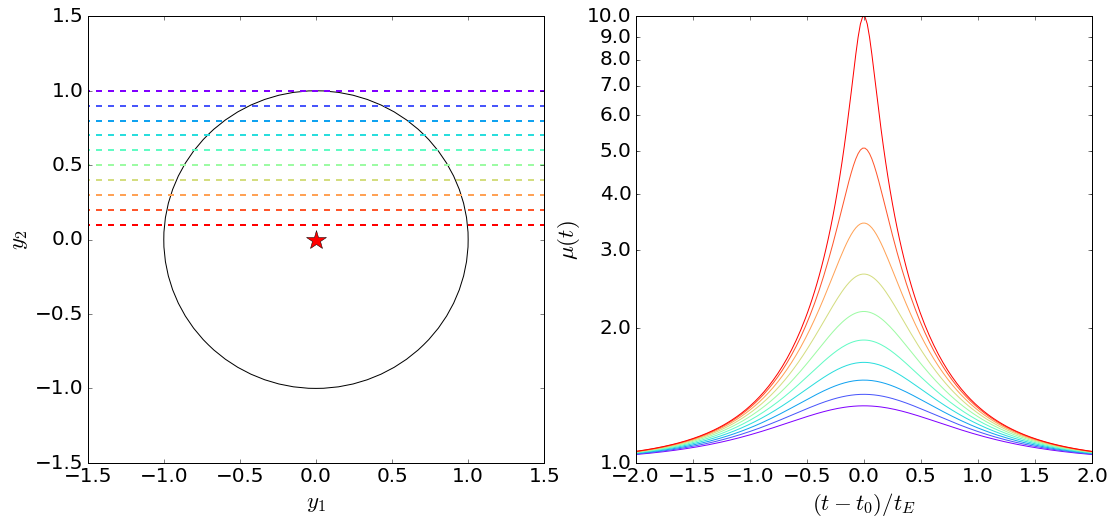

In [4]:
# import the usual stuff

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
import matplotlib.ticker as ticker

%matplotlib inline

# our problem can be phrased as this: given a lens with a given mass M and placed 
# at a given distance D_L, we want to compute the magnification of a source moving a velocity 
# v on a plane at distance D_S, knowing that the source passes at a minimal distance y0 from
# the lens at the time t0. 


# the Einstein radius 
def theta_e_func(M,DL,DS):
    mass=M*const.M_sun#.value
    G=const.G#.value
    c=c=const.c#.value
    aconv=180.0*3600.0/np.pi*u.arcsecond
    return((np.sqrt(4.0*(G*mass/c/c).to('kpc')*(DS-DL)/DL/DS/u.kpc))*aconv)

# the Einstein radius crossing time
def EinsteinCrossTime(M,DL,DS,v):
    theta_e=theta_e_func(M,DL,DS)
    return(((theta_e.to('radian').value*DL*u.kpc).to('km')
            /v/u.km*u.s).to('day'))
            
# the distance of the source from the lens as a function of time
def yt(tE,y0,t0,t):
    return (np.sqrt(y0**2+((t-t0)/tE)**2))

# the lens magnification as a function of time
def mut_func(tE,y0,t0,t):
    y=yt(tE,y0,t0,t)
    return ((y**2+2)/y/np.sqrt(y**2+4))

# set up the lens model and the monitoring time

M_lens=0.3 # solar masses
DL=4.0 # kpc
DS=8.0 # kpc
vel=200 # km/s

# initialize the impact parameters
y0=np.linspace(1.0,0.1,10)
# passage at the minimum distance from the lens
t0=365 # days
# compute the Einstein radius crossing time 
t_einst=EinsteinCrossTime(M_lens,DL,DS,vel).value # days
t=t0+np.linspace(-2,2,200)*t_einst



xx=[-2,2]

fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[1].set_ylim([1.0,10.0])
ax[1].set_xlim([-2,2])
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$(t-t_0)/t_E$',fontsize=23)
ax[1].set_ylabel(r'$\mu(t)$',fontsize=23)
ax[1].set_yticks(np.arange(1, 11, 1.0))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

circle=plt.Circle((0,0),1,color='black',fill=False)
ax[0].set_xlim([-1.5,1.5])
ax[0].set_ylim([-1.5,1.5])
ax[0].add_artist(circle)
ax[0].plot([0.0],[0.0],'*',markersize=20,color='red')
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)

from matplotlib.pyplot import cm 
color=iter(cm.rainbow(np.linspace(0,1,y0.size)))

# loop over the impact parameters and plot the light curves
for i in range(y0.size):
    c=next(color)
    mut=mut_func(t_einst,y0[i],t0,t)
    ax[1].plot((t-t0)/t_einst,mut,'-',color=c)
    yy=[y0[i],y0[i]]
    ax[0].plot(xx,yy,'--',color=c,lw=2)

ax[0].set_xlabel(r'$y_1$',fontsize=23) 
ax[0].set_ylabel(r'$y_2$',fontsize=23)

# Fitting the light curve to learn the lens-source parameters

We illustrate here how light curves are fitted to extract lens-source parameters. We begin by generating some fake data starting from an input model. The parameters entering the calculation are listed here below, including the chosen values for the input model

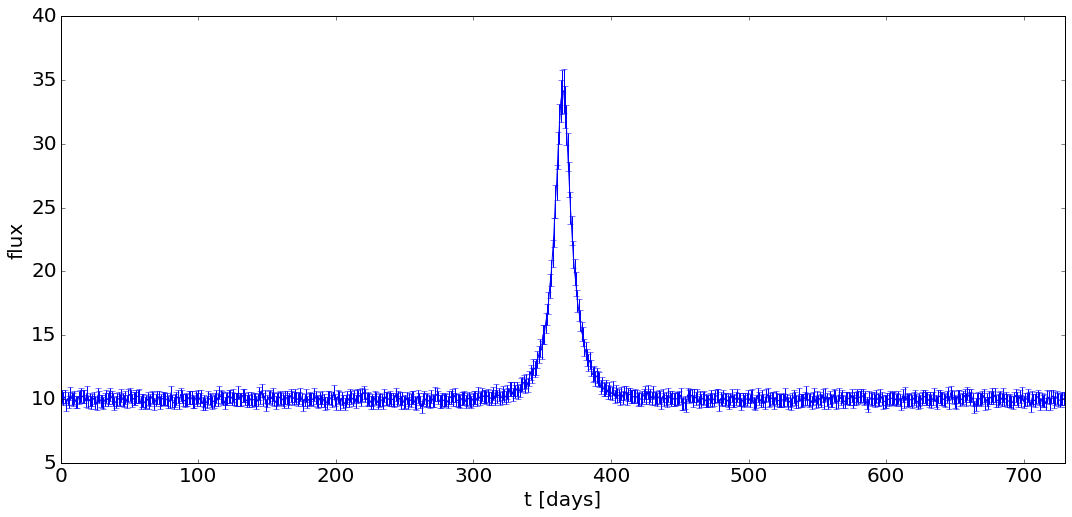

In [7]:
# input parameters for the light-curve
t=np.linspace(0,730,730)
M_lens=0.3 # solar masses
DL=4.0 # kpc
DS=8.0 # kpc
vel=210 # km/s
y0=0.3
t0=365.0 # days
flux0=10.0 # some arbitrary flux unit

t_einst=EinsteinCrossTime(M_lens,DL,DS,vel).value
# lightcurve plus random noise
mut=flux0*(mut_func(t_einst,y0,t0,t)+(np.random.randn(len(t))*0.02))

# we assign to the data some errors, which we assume to be a 
# constant fraction of the measurement
emut=mut*0.05

# data representation
fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

fig.savefig('simulated_lc.png')

The light-curve shown above is totally unrealistic. The monitoring of the source stars requires the usage of dedicated telescopes over a long period of time. In addition, the target star is typically observable from a given location during limited periods of time.

In order to fit the data, we use the python package ```lmfit```. This package allows to build complex fitting models for non-linear least-squares problems. The implementation of the fit shown here was obtained by closely following the examples in the package documentation, which can be found at this link: http://cars9.uchicago.edu/software/python/lmfit_MinimizerResult/intro.html

We begin by setting up some initial guesses for the model parameter, storing them in a ```lmfit.Parameter``` object. Then, we write the function to be minimized, a.k.a. the *objective* function:

In [11]:
import lmfit

# initial guesses
p = lmfit.Parameters()
p.add_many(('t0', 360.,True,0,720), ('M_lens', 0.5, True, 0.001, 100.0), 
           ('DL', 5., True, 0.1, 10.), ('DS', 10., True, 5., 15.), 
           ('vel',200,True,100.,300.), ('y0',0.2, True, 0.01,1.0),
           ('flux0',12, True, 8,12.0))

# objective function
def residual(p):

    v = p.valuesdict()
    t_einst=EinsteinCrossTime(v['M_lens'],v['DL'],v['DS'],v['vel']).value
    res=(mut_func(t_einst,v['y0'],v['t0'],t)*v['flux0']-mut)/emut

    return (res)

This function simply compares the model to the data, returning its residuals.

The next step is use a minimizer to minimize the objective function (i.e. the residuals). Several algorithms are available in lmfit. Here, we perform the minimization using the Nelder-Mead fitting method.

[[Variables]]
    t0:       365.002446 (init= 360)
    M_lens:   0.22162718 (init= 0.5)
    DL:       5.17859669 (init= 5)
    DS:       9.89082660 (init= 10)
    vel:      200.691012 (init= 200)
    y0:       0.29997367 (init= 0.2)
    flux0:    9.98550295 (init= 12)
[[Correlations]] (unreported correlations are <  0.500)


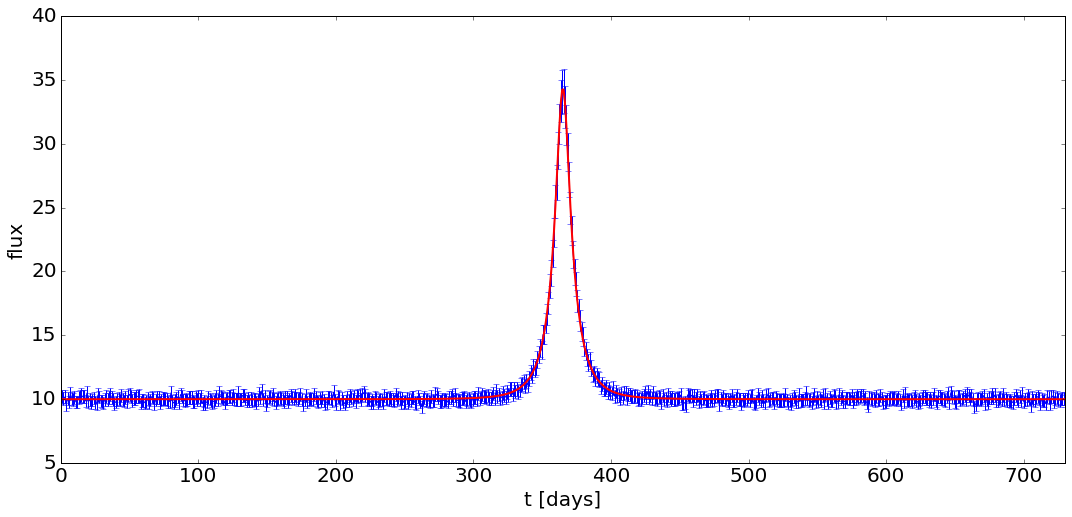

In [14]:
# minimize the objective function using the Nelder-Mead method
mi = lmfit.minimize(residual, p, method='Nelder')
# print report on the fit
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

# plot the maximum likelihood solution on the top of the data
fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

t_einst=EinsteinCrossTime(mi.params['M_lens'],mi.params['DL'],
                          mi.params['DS'],mi.params['vel']).value
ax.plot(t,mi.params['flux0']*mut_func(t_einst,mi.params['y0'],
                                      mi.params['t0'],t),'r',lw=2)
fig.savefig('simulated_lc.png')

To derive the probability distribution for the parameters, we use a bayesian approach. More precisely, we perform a Bayesian sampling of the posterior distribution for the parameters using the ```emcee``` Markov Chain Monte Carlo package.  You need to have ```emcee``` installed to use this method.

The method requires to define a log-likelihood function, which is used to compute the  log-posterior probability of the model parameters as

$$
\ln P(p|d) \propto \ln P(d|p)+\ln P(p)
$$

The method (implemented in lmfit) assumes that the prior is uniform, i.e. $\ln P(p)=0$. 

The log-likelihood function is given by

$$
\ln P(d|p)=-\frac{1}{2}\sum_n \left[\frac{(model_n-data_n)^2}{s_n^2}+\ln 2\pi s_n^2\right]
$$

In [15]:
# log-likelihood function
def lnprob(p):
    from numpy import inf
    resid = residual(p)
    s = emut
    resid *= resid
    resid += np.log(2 * np.pi * s**2)
    lnp=-0.5 * np.sum(resid)
    if (np.isnan(lnp)):
        lnp=-1e10
    
    return lnp

We can not perform the sampling of the posterior distribution and display the results:

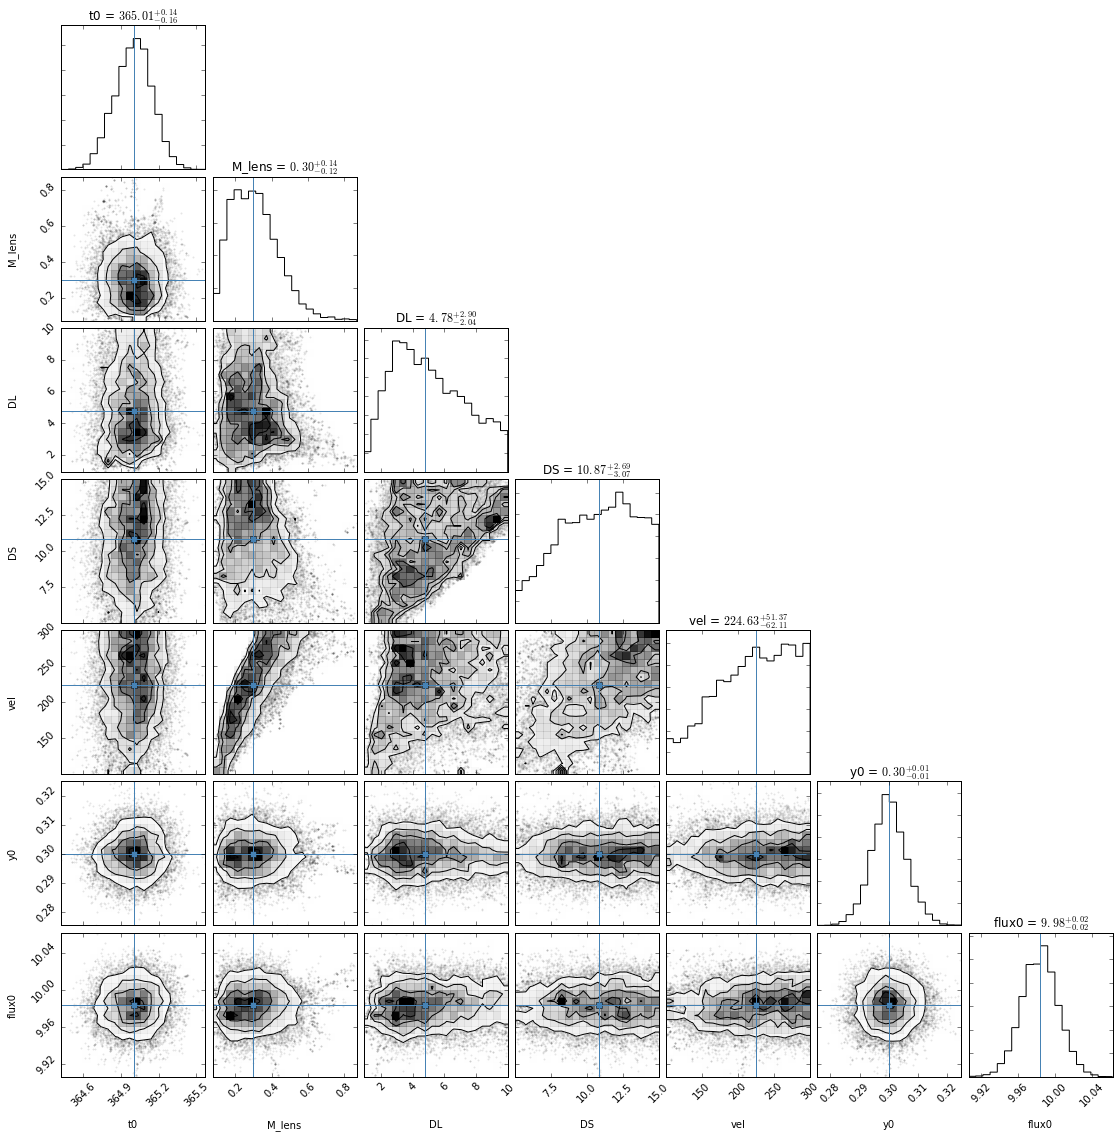

In [17]:
# build a general minimizer for curve fitting and optimization.
mini = lmfit.Minimizer(lnprob, mi.params, nan_policy='propagate')
# sampling of the posterion distribution
res = mini.emcee(burn=300, steps=2000, thin=10, params=mi.params)

# show corner plot (confidence limits, parameter distributions, correlations)
import corner
figure=corner.corner(res.flatchain, labels=res.var_names, 
                     truths=list(res.params.valuesdict().values()),
                     show_titles=True, title_kwargs={"fontsize": 12})
figure.savefig('corner_microlensing.png')

In [18]:
print("median of posterior probability distribution")
print('------------------------------------------')
lmfit.report_fit(res.params)

median of posterior probability distribution
------------------------------------------
[[Variables]]
    t0:       365.005389 +/- 0.150172 (0.04%) (init= 365.0024)
    M_lens:   0.29572066 +/- 0.129853 (43.91%) (init= 0.2216272)
    DL:       4.77833889 +/- 2.478843 (51.88%) (init= 5.178597)
    DS:       10.8725461 +/- 2.892918 (26.61%) (init= 9.890827)
    vel:      224.631948 +/- 56.98840 (25.37%) (init= 200.691)
    y0:       0.29996274 +/- 0.005893 (1.96%) (init= 0.2999737)
    flux0:    9.98410492 +/- 0.019299 (0.19%) (init= 9.985503)
[[Correlations]] (unreported correlations are <  0.100)
    C(M_lens, vel)               =  0.751 
    C(DL, DS)                    =  0.428 
    C(DS, vel)                   =  0.378 
    C(DL, vel)                   =  0.212 
    C(M_lens, DS)                = -0.173 
    C(M_lens, DL)                = -0.123 


There are strong correlations between the parameters ```vel```, ```M_lens```,```DL```, and ```DS```, which highlight the microlensing degeneracy: with a single microlensing event, it is only possible to constrain the parameter $t_E$, which is a combination of all these parameters. 

This can be seen in the other example below:

[[Variables]]
    t0:      365.003149 (init= 360)
    tE:      18.2093968 (init= 20)
    y0:      0.29999567 (init= 0.2)
    flux0:   9.98544634 (init= 12)
[[Correlations]] (unreported correlations are <  0.500)


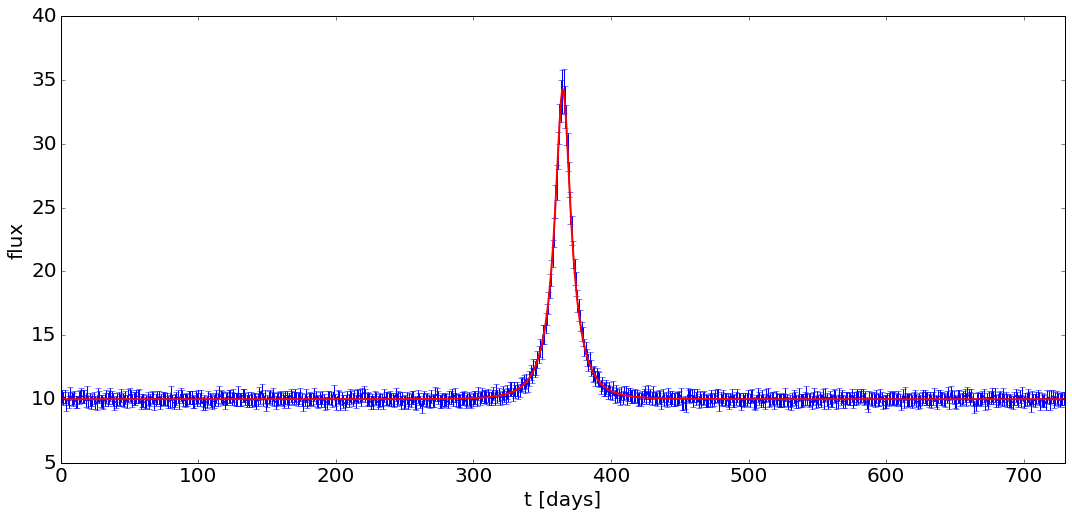

In [20]:
import lmfit

# initial guesses
p = lmfit.Parameters()
p.add_many(('t0', 360.,True,0,720), ('tE', 20, True, 1, 100.0), 
           ('y0',0.2, True, 0.01,1.0),('flux0',12, True, 8,12.0))

# new functions

def mut_func_new(tE,y0,t0,t):
    y=yt_new(tE,y0,t0,t)
    return ((y**2+2)/y/np.sqrt(y**2+4))

def yt_new(tE,y0,t0,t):
    return (np.sqrt(y0**2+((t-t0)/tE)**2))


# objective function
def residual(p):

    v = p.valuesdict()
    res=(mut_func_new(v['tE'],v['y0'],v['t0'],t)*v['flux0']-mut)/emut

    return (res)

mi = lmfit.minimize(residual, p, method='Nelder')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)

fig,ax=plt.subplots(1,1,figsize=(18,8))
ax.errorbar(t, mut,emut)
ax.set_xlabel('t [days]',fontsize=20)
ax.set_ylabel('flux',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.set_xlim([0,730])

ax.plot(t,mi.params['flux0']*mut_func_new(mi.params['tE'],
                                          mi.params['y0'],mi.params['t0'],t),'r',lw=2)

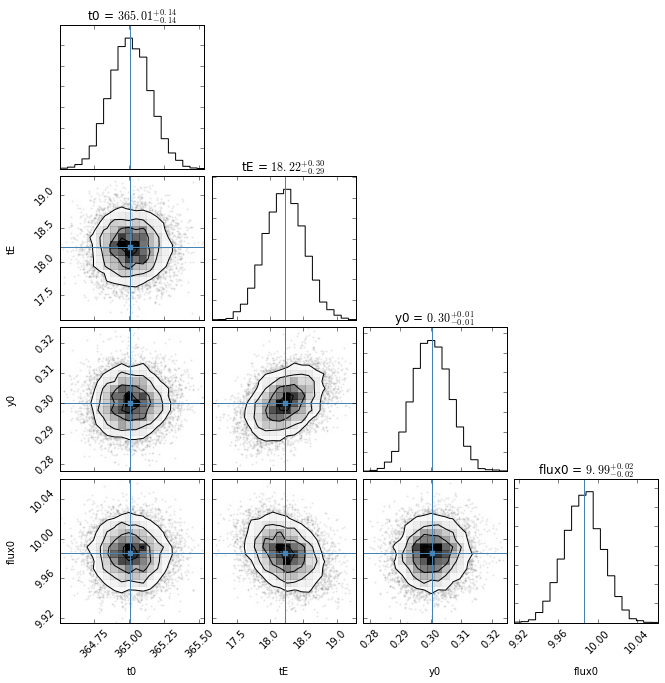

In [21]:
# the log-likelihood function remains the same

mini = lmfit.Minimizer(lnprob, mi.params, nan_policy='propagate')
res = mini.emcee(burn=300, steps=1200, thin=10, params=mi.params)

import corner
figure=corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()),show_titles=True, title_kwargs={"fontsize": 12})
figure.savefig('corner_microlensing_tE.png')

In [46]:
print("median of posterior probability distribution")
print('------------------------------------------')
lmfit.report_fit(res.params)

median of posterior probability distribution
------------------------------------------
[[Variables]]
    t0:      365.004179 +/- 0.095479 (0.03%) (init= 365.0026)
    tE:      18.3517078 +/- 0.203377 (1.11%) (init= 18.34767)
    y0:      0.30089541 +/- 0.004231 (1.41%) (init= 0.3007959)
    flux0:   9.99069071 +/- 0.013495 (0.14%) (init= 9.990946)
[[Correlations]] (unreported correlations are <  0.100)
    C(tE, y0)                    =  0.377 
    C(tE, flux0)                 = -0.287 


Note that $t_E$ is constrained very well by the data.